In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts

def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()
    
def load_file(unit, file_type='rms'):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df = pd.read_csv('../data/raw/train/unit{}_{}.csv'.format(unit_name, file_type))
    if file_type == 'rms':
        df = exclude_physical_anml(df)
    return df

def transform_column(df_input):
    num_features = df_input.columns[1:]
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features)
    ])
    np_pipelined = full_pipeline.fit_transform(df_input)
    df_pipelined = pd.DataFrame(np_pipelined, index=df_input.index)
    return df_pipelined

In [13]:
rms_0 = load_file(0, 'rms')
#rms_0[rms_0.columns[1:]]
#rms_0_pipelined = transform_column(rms_0)
tsne_model_0 = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
tsne_vectors = tsne_model_0.fit_transform(rms_0[rms_0.columns[1:]])

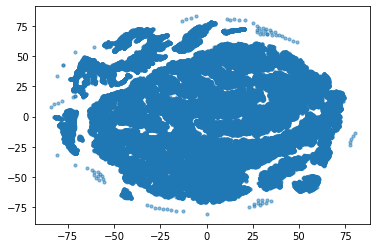

In [15]:
plt.scatter(x=tsne_vectors[:, 0], y=tsne_vectors[:, 1], marker='o', alpha=0.5, s=10)
plt.show()

In [16]:
rms_1 = load_file(1, 'rms')
tsne_model_1 = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
tsne_vectors_1 = tsne_model_1.fit_transform(rms_1[rms_1.columns[1:]])

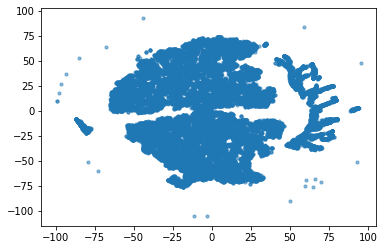

In [17]:
plt.scatter(x=tsne_vectors_1[:, 0], y=tsne_vectors_1[:, 1], marker='o', alpha=0.5, s=10)
plt.show()

Merging all train data and plot on 2D plain using TSNE

In [18]:
units = range(0, 20)
df = pd.DataFrame()
for idx, unit in enumerate(units):
    file_name = "../data/raw/train/unit{}_rms.csv".format(unit)
    file_df = pd.read_csv(file_name)
    df.append(file_df)
df

FileNotFoundError: [Errno 2] File b'../data/raw/train/unit0_rms.csv' does not exist: b'../data/raw/train/unit0_rms.csv'